In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util 

In [4]:
archive = util.load_pkl("/home/akarsh_sakana_ai/spaghetti-data/run_0.5", "archive")

In [5]:
cppn = CPPN(4, 16, 'tanh')
cppn = FlattenCPPNParameters(cppn)

fn = jax.jit(cppn.generate_image)

img_archive = jnp.stack([fn(params) for params in tqdm(archive['pheno']['params'])])
img_archive.shape

ParameterReshaper: 931 parameters detected for optimization.


  0%|          | 0/6801 [00:00<?, ?it/s]

(6801, 128, 128, 3)

In [6]:
img_archive.shape

(6801, 128, 128, 3)

In [7]:
class BigCPPN(nn.Module):
    n_layers: int
    d_hidden: int
    nonlin: str = 'tanh' # use tanh or relu
    residual: bool = False
    layernorm: bool = False

    @nn.compact
    def __call__(self, x, idx):
        class_embd = nn.Embed(num_embeddings=6801, features=128)(idx)
        x = jnp.concatenate([x, class_embd], axis=-1)

        intermediate_features = [x]
        for i_layer in range(self.n_layers):
            xp = nn.Dense(self.d_hidden)(x)
            xp = getattr(nn, self.nonlin)(xp)
            if self.layernorm:
                xp = nn.LayerNorm()(xp)
            x = x + xp if (self.residual and i_layer>0) else xp
            intermediate_features.append(x)
        x = nn.Dense(3)(x)
        intermediate_features.append(x)
        rgb = jax.nn.sigmoid(x)
        return rgb, intermediate_features

    def generate_image(self, params, idx, img_size=128, intermediate_features=False):
        x = y = jnp.linspace(-1, 1, img_size)
        x, y = jnp.meshgrid(x, y, indexing='ij')
        d = jnp.sqrt(x**2 + y**2)
        xyd = jnp.stack([x, y, d], axis=-1)
        rgb, features = jax.vmap(jax.vmap(partial(self.apply, params), in_axes=(0, None)), in_axes=(0, None))(xyd, idx)
        if intermediate_features:
            return rgb, features
        else:
            return rgb

import evosax
class FlattenCPPNParameters():
    def __init__(self, cppn):
        self.cppn = cppn

        rng = jax.random.PRNGKey(0)
        self.param_reshaper = evosax.ParameterReshaper(self.cppn.init(rng, jnp.zeros((3,)), jnp.array(0)))
        self.n_params = self.param_reshaper.total_params
    
    def init(self, rng, x, idx):
        params = self.cppn.init(rng, x, idx)
        return self.param_reshaper.flatten_single(params)

    def generate_image(self, params, idx, img_size=128, intermediate_features=False):
        params = self.param_reshaper.reshape_single(params)
        return self.cppn.generate_image(params, idx, img_size=img_size, intermediate_features=intermediate_features)
    

In [50]:
def loss_fn(params, rng):
    idx = jax.random.randint(rng, (128, ), minval=0, maxval=6801)
    img = jax.vmap(cppn.generate_image, in_axes=(None, 0))(params, idx)
    loss = ((img_archive[idx] - img)**2).mean()
    return loss

@jax.jit
def train_step(state, rng):
    loss, grad = jax.value_and_grad(loss_fn)(state.params, rng)
    state = state.apply_gradients(grads=grad)
    return state, loss

cppn = BigCPPN(8, 256, 'relu')
# cppn = FlattenCPPNParameters(cppn)
rng = jax.random.PRNGKey(0)
params = cppn.init(rng, jnp.zeros((3,)), jnp.array(0))

tx = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=None, params=params, tx=tx)

losses = []
pbar = tqdm(range(10000))
for t in pbar:
    rng = jax.random.PRNGKey(t)
    state, loss = train_step(state, rng)
    losses.append(loss)
    if t % 100 == 0:
        pbar.set_postfix(loss=loss.item())

losses = np.array(jnp.stack(losses))
params = state.params

  0%|          | 0/10000 [00:00<?, ?it/s]

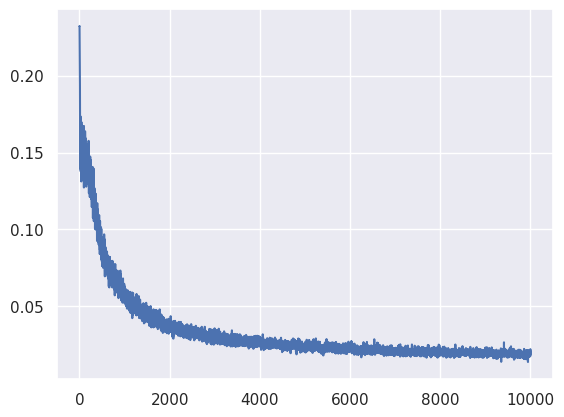

In [51]:
plt.plot(losses)

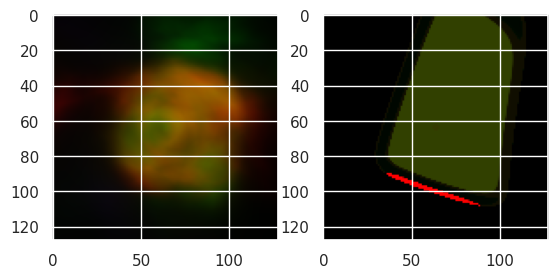

In [61]:
# idx = 6584
idx = 6750
idx = 6326
img = cppn.generate_image(params, jnp.array(idx))
plt.subplot(121); plt.imshow(img)
plt.subplot(122); plt.imshow(img_archive[idx])